## Homework 1. Senators dataset

This dataset contains information on how each senator votes on 542 different bills etc, there are 100 senators in totall; +1 means voted for, -1 means voted against and 0 means abstained. We will use **1-D PCA** to see if we can find the vector of maximum variation.

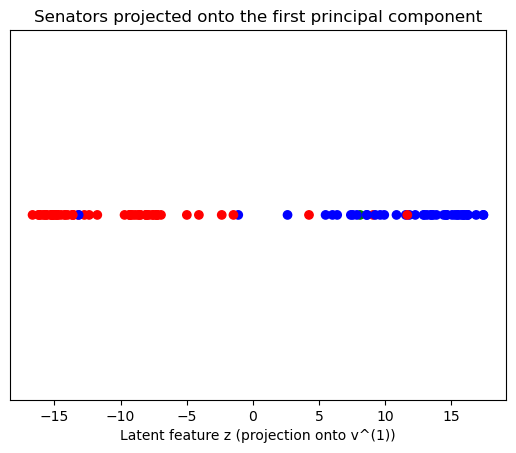

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# read in data
df = pd.read_csv('../data/senators.csv').set_index('senator')
# get the party affiliation
parties = df.index.str.split("-").str[-1]


# prep for 1-D PCA
X = df.to_numpy()

# calculate the covariance matrix
cov_matrix = np.cov(X, rowvar=False, bias=False)

# eigenvectors and eigenvalues, sorted in ascending order
# for smallest to largest eivenvalue, get the largest one
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
dominant_eigenvector = eigvecs[:, -1]
print(f'The direction of maximum variance (ie the dominant eigenvector) is {dominant_eigenvector}')


# calculating encoding per senator
encoding = X @ dominant_eigenvector 
decoding = np.outer(encoding, dominant_eigenvector)

# Encoding: 1D → single-column DataFrame
encoding_df = pd.DataFrame(
    encoding,
    index=df.index,
    columns=["PC1_encoding"]
)

# Decoding: same shape as X → keep original feature names
decoding_df = pd.DataFrame(
    decoding,
    index=df.index,
    columns=df.columns
)

# plotting along party lines
fig, ax = plt.subplots()
colors = parties.map({'D': 'blue', 'R': 'red', 'I': 'green'})
ax.scatter(encoding, [0]*len(encoding), c=colors)
ax.set_yticks([])  # hide y-axis since it’s 1D
ax.set_xlabel("Latent feature z (projection onto v^(1))")
ax.set_title('Senators projected onto the first principal component')
ax.set_ylim(-0.05, 0.05)   # squish y-axis close to 0

plt.show()

## assessing best and worst at decoding

errors = ((df - decoding_df) ** 2).mean(axis=1)
errors.name = "MSE"

best_decoded = errors.nsmallest(5)   # 5 senators with lowest MSE
worst_decoded = errors.nlargest(5)   # 5 senators with highest MSE

### Interpretation: what is $v^{i}$ exactly?

$v^{i}$ represents the direction of maximum variance, ie the direction where there is clearest separation in voting behavior. In the chart above, we see that this divide is clearest in the party affiliation. While this is not actually the party affiliation, it is quite similar as thats the direction which separates voting the clearest. 

In [6]:
selected_senators = ['Barack H. Obama-D', 'John S. McCain-R', 'Ted Stevens-R']

print("Selected senators and their PC1 projections:")
for senator in selected_senators:
    encoding_val = encoding_df.loc[senator, 'PC1_encoding']
    mse_error = errors.loc[senator]
    print(f"{senator}: PC1 = {encoding_val:.3f}, MSE = {mse_error:.3f}")

Selected senators and their PC1 projections:
Barack H. Obama-D: PC1 = 7.555, MSE = 0.195
John S. McCain-R: PC1 = -9.702, MSE = 0.751
Ted Stevens-R: PC1 = -13.648, MSE = 0.645


PC1 Projections (Ideological Positioning):

Obama (7.555): Strong positive value = liberal end of the spectrum
McCain (-9.702): Moderate negative value = conservative, but not extremely so
Stevens (-13.648): Most negative value = very conservative end

The PC1 clearly captures the liberal-conservative ideological axis, with positive values = Democrats/liberals and negative values = Republicans/conservatives.
MSE (Reconstruction Errors):

Obama (0.195): Very low error = his voting pattern is well-explained by the main ideological dimension
McCain (0.751): Highest error = his voting pattern is poorly captured by just the liberal-conservative axis
Stevens (0.645): Moderate error = reasonably well-explained by ideology alone

### Which senators vote along the primary axis the most often (likely interpreted as party lines)? 

In [2]:
best_decoded

senator
Robert Menendez-D             0.085103
Jim W. DeMint-R               0.178241
John H. 'Johnny' Isakson-R    0.182145
Mel Martinez-R                0.193517
Barack H. Obama-D             0.195432
Name: MSE, dtype: float64

In [3]:
worst_decoded

senator
Olympia J. Snowe-R                0.994183
Arlen Spector-R                   0.936055
James Merrill 'Jim' Jeffords-I    0.852945
Michael 'Mike' DeWine-R           0.838235
Susan M. Collins-R                0.814496
Name: MSE, dtype: float64